## importing dependencies 



In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

### importing the training data of GOOG historical prices

In [2]:
data = pd.read_csv('trainData.csv') 


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


## choosing the close column 


In [4]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #turning the Close column to numeric
data = data.dropna() #romeving the NA values
trainData = data.iloc[:,4:5].values #selecting only the closing prices for training


## scaling the values in the range of 0-1 for best preformances 

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

## preparing the data for LSTM
 since its a time series problem we took 60 as timestep for our learning : given *60 closing values* as an input data the *61st value* is our output

In [6]:
X_train = []
y_train = []

for i in range (60,1149): #60 : timestep // 1149 : length of the data
    X_train.append(trainData[i-60:i,0]) 
    y_train.append(trainData[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

ps : LSTM take a 3D tensor (seq_len,timestep,batch_size)

In [7]:
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
X_train.shape

(1089, 60, 1)

## building the model 

In [8]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")

In [9]:
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)

Epoch 1/20
35/35 - 21s - loss: 0.0386 - 21s/epoch - 591ms/step
Epoch 2/20
35/35 - 6s - loss: 0.0105 - 6s/epoch - 179ms/step
Epoch 3/20
35/35 - 6s - loss: 0.0095 - 6s/epoch - 160ms/step
Epoch 4/20
35/35 - 6s - loss: 0.0103 - 6s/epoch - 173ms/step
Epoch 5/20
35/35 - 6s - loss: 0.0104 - 6s/epoch - 167ms/step
Epoch 6/20
35/35 - 6s - loss: 0.0092 - 6s/epoch - 162ms/step
Epoch 7/20
35/35 - 6s - loss: 0.0065 - 6s/epoch - 179ms/step
Epoch 8/20
35/35 - 6s - loss: 0.0064 - 6s/epoch - 165ms/step
Epoch 9/20
35/35 - 6s - loss: 0.0056 - 6s/epoch - 167ms/step
Epoch 10/20
35/35 - 6s - loss: 0.0068 - 6s/epoch - 174ms/step
Epoch 11/20
35/35 - 6s - loss: 0.0060 - 6s/epoch - 163ms/step
Epoch 12/20
35/35 - 6s - loss: 0.0052 - 6s/epoch - 176ms/step
Epoch 13/20
35/35 - 6s - loss: 0.0064 - 6s/epoch - 183ms/step
Epoch 14/20
35/35 - 6s - loss: 0.0064 - 6s/epoch - 163ms/step
Epoch 15/20
35/35 - 6s - loss: 0.0050 - 6s/epoch - 180ms/step
Epoch 16/20
35/35 - 7s - loss: 0.0049 - 7s/epoch - 195ms/step
Epoch 17/20
35/

### ploting the training loss


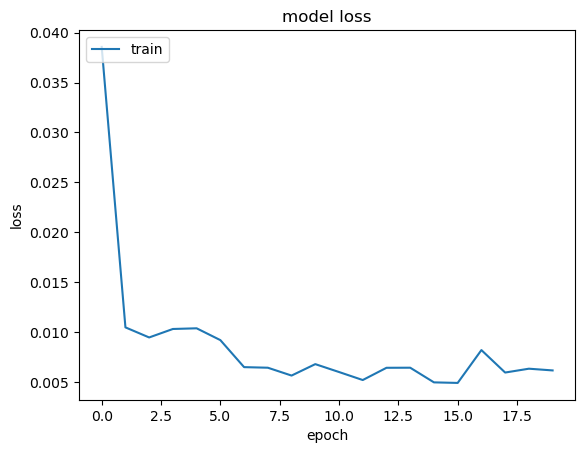

In [10]:
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### testing the model on new data


In [11]:
testData = pd.read_csv('GOOG.csv') #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep,length): #doing the same preivous preprocessing 
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(192, 60, 1)

In [12]:
y_pred = model.predict(X_test) #predicting the new values

6/6 [==============================] - 3s 63ms/step


In [13]:
predicted_price = sc.inverse_transform(y_pred) #inversing the scaling transformation for ploting 

### ploting the results

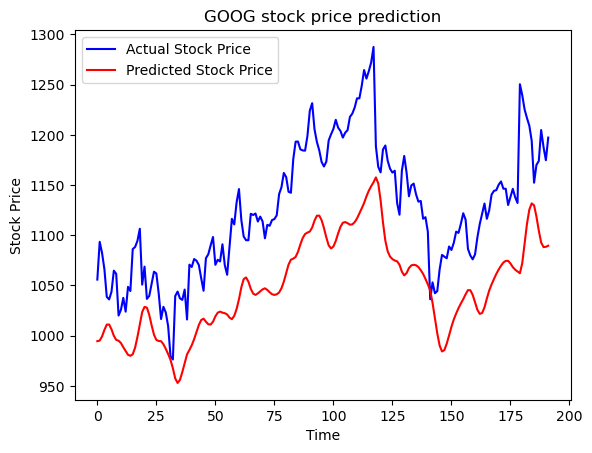

In [14]:
plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('GOOG stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()